Configurations: 81
Atomic cells: 272
Edges kept (not drawn): 405


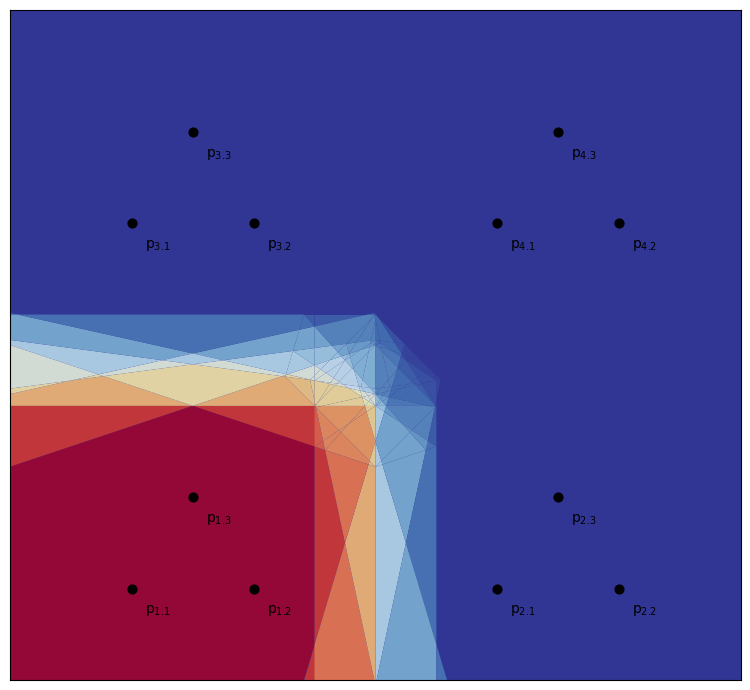

Saved SVG: combinatorial_membership_voronoi.svg


In [4]:
#@title discrete combinatorial membership degree
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Polygon as MplPolygon
from scipy.spatial import Voronoi
from shapely.geometry import box, LineString
from shapely.ops import unary_union, polygonize
import itertools

# ---------------------------
# Data: 4 regions × 3 prototypes
# ---------------------------
PROTOTYPES = {
    'r1': [(0.50000000, 0.25000000), (1.50000000, 0.25000000), (1.00000000, 1.00000000)],
    'r2': [(3.50000000, 0.25000000), (4.50000000, 0.25000000), (4.00000000, 1.00000000)],
    'r3': [(0.50000000, 3.25000000), (1.50000000, 3.25000000), (1.00000000, 4.00000000)],
    'r4': [(3.50000000, 3.25000000), (4.50000000, 3.25000000), (4.00000000, 4.00000000)],
}

# ---------------------------
# Utilities
# ---------------------------
def generate_configurations(prototypes):
    return list(itertools.product(*prototypes.values()))


def create_atomic_cells(configurations, bbox):
    """Create atomic polygons by overlaying Voronoi edges for every configuration."""
    all_lines = []
    for config in configurations:
        points = np.array(config)
        try:
            vor = Voronoi(points)
        except Exception:
            continue

        # finite ridges
        for simplex in vor.ridge_vertices:
            if all(i >= 0 for i in simplex):
                i, j = simplex
                p1 = vor.vertices[i]; p2 = vor.vertices[j]
                line = LineString([p1, p2])
                clipped = line.intersection(bbox)
                if not clipped.is_empty:
                    if isinstance(clipped, LineString):
                        all_lines.append(clipped)
                    else:
                        try:
                            for geom in clipped.geoms:
                                all_lines.append(geom)
                        except Exception:
                            all_lines.append(clipped)

        # infinite ridges
        center = vor.points.mean(axis=0)
        for pointidx, simplex in zip(vor.ridge_points, vor.ridge_vertices):
            simplex = np.asarray(simplex)
            if np.any(simplex < 0):
                finite_inds = simplex[simplex >= 0]
                if len(finite_inds) == 0:
                    continue
                i = finite_inds[0]
                t = vor.points[pointidx[1]] - vor.points[pointidx[0]]
                nrm = np.linalg.norm(t)
                if nrm == 0:
                    continue
                t = t / nrm
                n = np.array([-t[1], t[0]])
                midpoint = vor.points[pointidx].mean(axis=0)
                direction = np.sign(np.dot(midpoint - center, n)) * n
                far_point = vor.vertices[i] + direction * 20.0
                line = LineString([vor.vertices[i], far_point])
                clipped = line.intersection(bbox)
                if not clipped.is_empty:
                    if isinstance(clipped, LineString):
                        all_lines.append(clipped)
                    else:
                        try:
                            for geom in clipped.geoms:
                                all_lines.append(geom)
                        except Exception:
                            all_lines.append(clipped)

    # bbox boundary to close domain
    coords = list(bbox.exterior.coords)
    for i in range(len(coords) - 1):
        all_lines.append(LineString([coords[i], coords[i + 1]]))

    if all_lines:
        merged = unary_union(all_lines)
        if hasattr(merged, 'geoms'):
            atomic_polygons = list(polygonize(merged))
        else:
            atomic_polygons = list(polygonize([merged]))
    else:
        atomic_polygons = [bbox]

    valid_polygons = [p for p in atomic_polygons if p.is_valid and (not p.is_empty) and p.area > 1e-12]
    return valid_polygons


def calculate_membership_degrees(atomic_cells, configurations, target_region=0):
    """Membership degree per atomic cell (fraction of configurations where rep point closest to target prototype)."""
    membership_degrees = {}
    for idx, cell in enumerate(atomic_cells):
        rep = cell.centroid
        if not cell.contains(rep):
            rep = cell.representative_point()
        count = 0
        for config in configurations:
            pts = np.array(config)
            dists = np.linalg.norm(pts - np.array([rep.x, rep.y]), axis=1)
            closest_idx = int(np.argmin(dists))
            if closest_idx == target_region:
                count += 1
        membership_degrees[idx] = (count / len(configurations)) if configurations else 0.0
    return membership_degrees


def extract_edges_from_polygons(polygons, round_digits=9):
    """Map undirected edges -> {'line': LineString, 'polys': [poly_idx,...]}."""
    edges = {}
    for idx, poly in enumerate(polygons):
        if not hasattr(poly, 'exterior'):
            continue
        coords = list(poly.exterior.coords)
        for i in range(len(coords) - 1):
            a = (round(coords[i][0], round_digits), round(coords[i][1], round_digits))
            b = (round(coords[i + 1][0], round_digits), round(coords[i + 1][1], round_digits))
            key_ab = (a, b); key_ba = (b, a)
            key = key_ab if key_ab <= key_ba else key_ba
            if key not in edges:
                edges[key] = {'line': LineString([a, b]), 'polys': []}
            if idx not in edges[key]['polys']:
                edges[key]['polys'].append(idx)
    return edges


def prune_edges_by_membership(edges_map, membership_degrees, keep_threshold=0.0):
    kept = []
    for key, entry in edges_map.items():
        poly_idxs = entry['polys']
        keep = False
        for pi in poly_idxs:
            val = membership_degrees.get(pi, 0.0)
            if val > keep_threshold:
                keep = True
                break
        if keep:
            kept.append({'line': entry['line'], 'polys': list(poly_idxs)})
    return kept

# ---------------------------
# Visualization with composite color to avoid seams; labels bottom-right in subscript-dot format
# ---------------------------
def visualize_atomic_cells_and_save_svg(
    atomic_cells,
    membership_degrees,
    prototypes,
    xlim=(-0.5, 5.5),
    ylim=(-0.5, 5.0),
    figsize=(np.float64(8.0), np.float64(7.0)),
    cmap_name='RdYlBu_r',
    alpha=0.85,
    savepath='membership_voronoi.svg'
):
    import matplotlib.pyplot as plt
    from matplotlib.patches import Rectangle, Polygon as MplPolygon

    fig, ax = plt.subplots(figsize=(figsize[0], figsize[1]))
    cmap = plt.get_cmap(cmap_name)

    # Background RGB (membership 0) as opaque RGB (ignore cmap alpha)
    bg_rgb = np.array(cmap(0.0)[:3], dtype=float)

    # Draw opaque background rectangle (so complement is colored)
    bg = Rectangle((xlim[0], ylim[0]), xlim[1] - xlim[0], ylim[1] - ylim[0],
                   facecolor=tuple(bg_rgb), edgecolor='none', zorder=0)
    ax.add_patch(bg)

    # Composite function: composite semi-transparent fg over bg and return opaque RGB
    def composite_rgb(m):
        fg_rgb = np.array(cmap(float(m))[:3], dtype=float)
        final = alpha * fg_rgb + (1.0 - alpha) * bg_rgb
        final = np.clip(final, 0.0, 1.0)
        return tuple(final.tolist())

    # Draw atomic polygons as opaque patches using composited RGB (no alpha)
    for idx, poly in enumerate(atomic_cells):
        m = membership_degrees.get(idx, 0.0)
        face_rgb = composite_rgb(m)
        coords = list(poly.exterior.coords)
        patch = MplPolygon(coords, closed=True, facecolor=face_rgb, edgecolor=face_rgb, linewidth=0.0, zorder=2)
        ax.add_patch(patch)
        # Fill holes with background if present
        if hasattr(poly, 'interiors') and len(poly.interiors) > 0:
            for interior in poly.interiors:
                hole_coords = list(interior.coords)
                hole_patch = MplPolygon(hole_coords, closed=True, facecolor=tuple(bg_rgb),
                                       edgecolor=tuple(bg_rgb), linewidth=0.0, zorder=3)
                ax.add_patch(hole_patch)

    # Draw prototypes (black) and labels using mathtext subscript with dot (e.g. p_{1.1})
    # Position labels bottom-right of each point to mimic nested subscripts.
    width = xlim[1] - xlim[0]
    height = ylim[1] - ylim[0]
    dx = 0.018 * width   # small right offset
    dy = -0.022 * height  # small downward offset (negative -> below the point)

    region_order = list(prototypes.keys())  # expect ['r1','r2','r3','r4']
    for region_idx, region_key in enumerate(region_order, start=1):
        protos = prototypes[region_key]
        for j, (x, y) in enumerate(protos, start=1):
            # draw black point
            ax.scatter([x], [y], color='black', s=40, zorder=10, marker='o')
            # label using mathtext with dot-subscript: e.g. "$\mathrm{p}_{1.1}$"
            dot_index = f"{region_idx}.{j}"
            label = "$\\mathrm{p}_{" + dot_index + "}$"
            # place at bottom-right offset (so subscript effect is visually bottom-right)
            ax.text(x + dx, y + dy, label, ha='left', va='top', fontsize=10, color='black', zorder=11)

    # Framing and aspect
    ax.set_xlim([xlim[0], xlim[1]])
    ax.set_ylim([ylim[0], ylim[1]])
    ax.set_aspect('1.0')
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

    plt.tight_layout()
    fig.savefig(savepath, bbox_inches='tight', format='svg')
    plt.show()
    plt.close(fig)

# ---------------------------
# Main
# ---------------------------
def main():
    prototypes = PROTOTYPES
    configurations = generate_configurations(prototypes)
    print(f"Configurations: {len(configurations)}")

    bbox = box(-1.0, -1.0, 11.0, 11.0)
    atomic_cells = create_atomic_cells(configurations, bbox)
    print(f"Atomic cells: {len(atomic_cells)}")

    membership_degrees = calculate_membership_degrees(atomic_cells, configurations, target_region=0)
    eps = 1e-12
    membership_degrees = {k: (0.0 if abs(v) <= eps else v) for k, v in membership_degrees.items()}

    # Edges extraction and pruning (not drawn by default)
    edges_map = extract_edges_from_polygons(atomic_cells, round_digits=9)
    edges_kept = prune_edges_by_membership(edges_map, membership_degrees, keep_threshold=0.0)
    print(f"Edges kept (not drawn): {len(edges_kept)}")

    out_filename = 'combinatorial_membership_voronoi.svg'
    visualize_atomic_cells_and_save_svg(
        atomic_cells,
        membership_degrees,
        prototypes,
        xlim=(-0.5, 5.5),
        ylim=(-0.5, 5.0),
        figsize=(np.float64(8.0), np.float64(7.0)),
        cmap_name='RdYlBu_r',
        alpha=0.85,
        savepath=out_filename
    )
    print(f"Saved SVG: {out_filename}")


if __name__ == "__main__":
    main()